# Notebook getting EarthCare data over regions of interest.

## To do:
- [x] read in model data
- [x] read in EarthCare data
- [x] time and area filter for EarthCare data
- [x] extract model data along satellite tracks (time and space) 'curtains'
- [x] interpolation to smooth the curtains?
- [ ] plot curtains 
- [ ] comparisons of model and satellite data

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# from pylab import *
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
import pandas as pd
import easygems.healpix as egh
import easygems.remap as egr
import matplotlib.pyplot as plt
import h5py
import datetime
import glob 
import intake
from pathlib import Path
import healpy
import cmcrameri as scm5

# plt.rcParams.update({'font.size': 14, 'font.family': 'TimesNewRoman', 'text.usetex': True})
# plt.rcParams['figure.dpi'] = 300
# rcParams['axes.linewidth'] = 1.5

In [10]:
batlow=plt.get_cmap(scm5.cm.batlow)

In [11]:
# %% function deinfitions
def interpolate_to_track(ds, track_lon, track_lat, clon_degrees, clat_degrees, suff, model, zoom):
    # Define the path for the weights file corresponding to this EC track
    weights_path = Path(
        f"/work/mh0492/m301067/hackaton25/auxiliary-files/weights/weights_ec_tracks_{suff}_{model}_zoom{str(zoom)}.nc"
    )

    if weights_path.is_file():
        print("Load existing interpolation weights for this EC track")
        weights = xr.open_dataset(weights_path)
    else:
        print("Compute weights using Delaunay triangulation")
        weights = egr.compute_weights_delaunay(
            points=(clon_degrees, clat_degrees),
            xi=(track_lon, track_lat),
        )
        # Save weights to a NetCDF file for future use
        weights.to_netcdf(weights_path)

    # Apply weights to interpolate the dataset
    ds_interpolated = xr.apply_ufunc(
        egr.apply_weights,
        ds,
        kwargs=weights,
        input_core_dims=[["cell"]],
        output_core_dims=[["track"]],
        output_dtypes=["f4"],
        vectorize=True,
        dask="parallelized",
        dask_gufunc_kwargs={
            "output_sizes": {"track": len(track_lon)},
        },
        keep_attrs=True,
        on_missing_core_dim='copy',
    )

    return ds_interpolated

In [12]:
def get_earthcare_dat(date, time, product='level2-CPR'):
    base='/work/mh0731/m301196/ecomip/ftp.eorc.jaxa.jp'
    products={'level1' : {'path' : 'eorc/CPR/1B/xCa/2024', 'pref' : 'ECA_J_CPR_NOM_1BS_' , 'mid': '', 'suff' : '_vCa_corr_xCa.nc'},
              'level2-CPR' : {'path' : 'CPR/2A/CPR_CLP/vBa', 'pref' : 'ECA_J_CPR_CLP_2AS_' , 'mid': '', 'suff' : '_04814E_vBa.h5' },
              'level2-CPR-DV' : {'path' :'CPR/2A/CPR_ECO/vBa', 'pref' : 'ECA_J_CPR_ECO_2AS_', 'mid': '', 'suff' : '_04814C_vBa.h5'},
              'level2-ATLID' : {'path' : 'ATL/2A/ATL_CLA/vBa', 'pref' : 'ECA_J_ATL_CLA_2AS_', 'mid': '', 'suff' : '_04876E_vBa.h5'},
    }

    # ECA_J_CPR_NOM_1BS_20240929T0829_20240929T0841_01920B_vCa_corr_xCa.nc
    # ECA_J_CPR_CLP_2AS_20250403T0845_20250403T0857_04814E_vBa.h5
    # ECA_J_CPR_ECO_2AS_20250403T0822_20250403T0833_04814C_vBa.h5
    # ECA_J_ATL_CLA_2AS_20250407T0823_20250407T0834_04876E_vBa.h5

    
    yy,mm,dd=date.split('-',2)
    hr,mn=time.split('T',1)[1].split(':',2)[0:2]
    target=datetime.datetime(int(yy),int(mm),int(dd),int(hr),int(mn))

    

    files=glob.glob(f"{base}/{products[product]['path']}/{yy}/{mm}/{dd}/{products[product]['pref']}{yy}{mm}{dd}*")
    times=np.zeros(len(files))

    file_datetime = datetime.datetime(int(yy),int(mm),int(dd),int(hr),int(mn))

    for i,file in enumerate(files):
        hr=file.split('T',1)[1].split('_',1)[0][0:2]
        mn=file.split('T',1)[1].split('_',1)[0][2:]
        file_datetime = datetime.datetime(int(yy),int(mm),int(dd),int(hr),int(mn))
        
        times[i]=(target-file_datetime).seconds


    times=np.abs(times)
    filename=files[np.where(times==np.min(times))[0][0]] #File with time closest to that which is specified

    print(filename)

    ec_lat,ec_lon,ec_time,ec_height=get_h5_geodat(filename) if product!='level1' else print('need to read netcdf file')

    return ec_lat, ec_lon, ec_time, ec_height, filename

    
    

In [13]:

def get_nest(ds):
    return ds.crs.healpix_order == "nest"


def get_section(ds,lons,lats,var):
    pnts = xr.DataArray(
    healpy.ang2pix(healpy.get_nside(ds[var]), lons, lats, lonlat=True, nest=get_nest(ds[var])),
    dims=("cell",),
    coords={"lon": (("cell",), lons), "lat": (("cell",), lats)},
)

    return ds[var].isel(cell=pnts).swap_dims({"cell": "lon"})#.plot(x="lon", yincrease=False)

In [14]:
def get_h5_geodat(filename):
    with h5py.File(filename, "r") as f:
        lat = f["ScienceData/Geo/latitude"][:]
        lon = f["ScienceData/Geo/longitude"][:]
        time = f["ScienceData/Geo/time"][:]
        height = f["ScienceData/Geo/height"][:]

    return lat,lon,time,height

def explore_h5(filename):
    with h5py.File(filename, "r") as f:
        def explorer(groupe, indent=0):
            for key in groupe:
                item = groupe[key]
                print("  " * indent + key, "(groupe)" if isinstance(item, h5py.Group) else "(dataset)")
                if isinstance(item, h5py.Group):
                    explorer(item, indent + 1)

        explorer(f)

In [37]:
def interpolate_to_track2(ds, weights_file, track_lon, track_lat):
   
    if weights_file.is_file():
        print("loading existing interpolation weights for this EC track")
        weights = xr.open_dataset(weights_file)
    else:
        print("computing weights using Delaunay triangulation")
        ds = (
            ds.rename_dims({"value": "cell"}).pipe(egh.attach_coords)
            if "value" in ds.dims
            else ds.pipe(egh.attach_coords)
        )
        weights = egr.compute_weights_delaunay(
            points=(ds["lon"].values, ds["lat"].values),
            xi=(track_lon, track_lat),
        )
        weights.to_netcdf(weights_file)

    # Apply weights to interpolate the dataset
    ds_interpolated = xr.apply_ufunc(
        egr.apply_weights,
        ds,
        kwargs=weights,
        input_core_dims=[["cell"]],
        output_core_dims=[["track"]],
        output_dtypes=["f4"],
        vectorize=True,
        dask="parallelized",
        dask_gufunc_kwargs={
            "output_sizes": {"track": len(track_lon)},
        },
        keep_attrs=True,
        on_missing_core_dim='copy'
    )

    return ds_interpolated

In [33]:
## Set some params

# model_day = "2020-04-03"  # format 'YYYY-MM-DD'   
# ec_time = "T19:20:00"  # format T'hh:mm:ss'
# ec_day= "2025-04-01" 
# ec_lon_min = -60  # degrees
# ec_lon_max = -20  # degrees
# ec_lat_min = 60  # degrees
# ec_lat_max = 80  # degrees

model_day = "2020-04-03"  # format 'YYYY-MM-DD'   
ec_time = "T16:16:00"  # format T'hh:mm:ss'
ec_day= "2025-04-01" 
ec_lon_min = -179  # degrees
ec_lon_max = 179  # degrees
ec_lat_min = -89  # degrees
ec_lat_max = 89  # degrees

modelsets=['casesm2_10km_nocumulus',
           'icon_d3hp003',
           'ifs_tco3999-ng5_rcbmf_cf',
           'nicam_gl11',
           'scream-dkrz',
           'um_glm_n2560_RAL3p3'
          ]

model='icon_d3hp003'   #--------> just for now, later we loop over the different models
zoom=7
current_location='EU'

####################################
## Now we need to get the 'curtain'#
####################################

ec_track_lat, ec_track_lon, ec_track_time, ec_track_height, ec_filename = get_earthcare_dat(ec_day, ec_time, product='level2-CPR')

# # # %% Trim track coordinates to be within the lat/lon bounds
valid_indices = np.where(
    (ec_track_lon >= ec_lon_min)
    & (ec_track_lon <= ec_lon_max)
    & (ec_track_lat >= ec_lat_min)
    & (ec_track_lat <= ec_lat_max)
)[0]
ec_track_lon = ec_track_lon[valid_indices]
ec_track_lat = ec_track_lat[valid_indices]
ec_track_time = ec_track_time[valid_indices]



/work/mh0731/m301196/ecomip/ftp.eorc.jaxa.jp/CPR/2A/CPR_CLP/vBa/2025/04/01/ECA_J_CPR_CLP_2AS_20250401T1616_20250401T1627_04788C_vBa.h5


In [38]:
cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"
)[current_location]
ds = cat[model](zoom=zoom).to_dask()
ds=ds.sel(time=f"{model_day}{ec_time}",method='nearest')
ds = ds.pipe(egh.attach_coords) 

# %% Interpolating the dataset to the EarthCARE track
ds_lon_deg = np.degrees(ds["lon"].values)
ds_lat_deg = np.degrees(ds["lat"].values)

suff1,suff2=ec_filename.split('_')[6:8]
suff=f"{suff1}_{suff2}"

# ds_curtain = interpolate_to_track(
#     ds, ec_track_lon, ec_track_lat, ds_lon_deg, ds_lat_deg, suff, model, zoom
# )

weights_file = Path(
        f"/work/mh0492/m301067/hackaton25/auxiliary-files/weights/weights_ec_tracks_{suff}_{model}_zoom{str(zoom)}.nc"
    )

ds_curtain = interpolate_to_track2(
    ds, weights_file, ec_track_lon, ec_track_lat
)


/work/bb1086/b383354/conda/envs/hackathon/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


computing weights using Delaunay triangulation


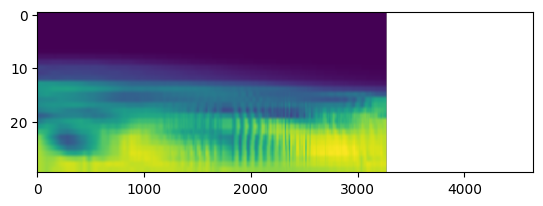

## Simple sections
Take a simple section along the track and plot - must select the vairable to plot

/tmp/ipykernel_2102423/499962155.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.round(np.linspace(min(ps),max(ps),len(ylabs)-1)))
/tmp/ipykernel_2102423/499962155.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.round(np.linspace(min(lons),max(lons),len(xlabs)-1),1))


Text(0.5, 0, 'Longitude (Degrees East)')

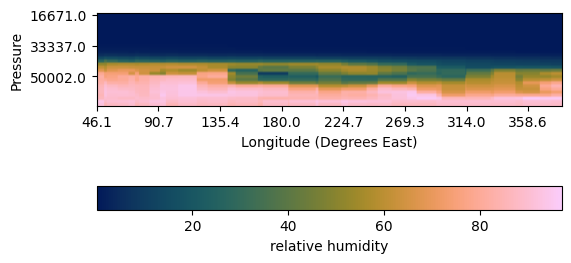

In [ ]:
var='hur'
longname=ds[var].long_name
sect = get_section(ds,ec_track_lon,ec_track_lat,'hur')

plot_imshow=True


fig,ax=plt.subplots(figsize=(6,7))
ps=sect['pressure'].values
lons=sect['lon'].values
if plot_imshow:
    cont=ax.imshow(sect.values,aspect=10,cmap=batlow)
    xlabs=ax.get_xticks()
    ylabs=ax.get_yticks()
    ax.set_yticklabels(np.round(np.linspace(min(ps),max(ps),len(ylabs)-1)))
    ax.set_xticklabels(np.round(np.linspace(min(lons),max(lons),len(xlabs)-1),1))
else:
    cont=ax.contourf(lons,ps,sect.values,levels=50,cmap=batlow)
    plt.gca().invert_yaxis()

plt.colorbar(cont,orientation='horizontal',label=longname)
ax.set_ylabel('Pressure')
ax.set_xlabel('Longitude (Degrees East)')


In [ ]:
def 
    plot_imshow=True


    fig,ax=plt.subplots(figsize=(6,7))
    ps=sect['pressure'].values
    lons=sect['lon'].values
    if plot_imshow:
        cont=ax.imshow(sect.values,aspect=10,cmap=batlow)
        xlabs=ax.get_xticks()
        ylabs=ax.get_yticks()
        ax.set_yticklabels(np.round(np.linspace(min(ps),max(ps),len(ylabs)-1)))
        ax.set_xticklabels(np.round(np.linspace(min(lons),max(lons),len(xlabs)-1),1))
    else:
        cont=ax.contourf(lons,ps,sect.values,levels=50,cmap=batlow)
        plt.gca().invert_yaxis()

    plt.colorbar(cont,orientation='horizontal',label=longname)
    ax.set_ylabel('Pressure')
    ax.set_xlabel('Longitude (Degrees East)')

## Plotting EarthCare data

The below is an example from the Curtains group for getting EarthCare data available on Levante and plotting.

/work/bb1086/b383354/conda/envs/hackathon/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/work/bb1086/b383354/conda/envs/hackathon/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


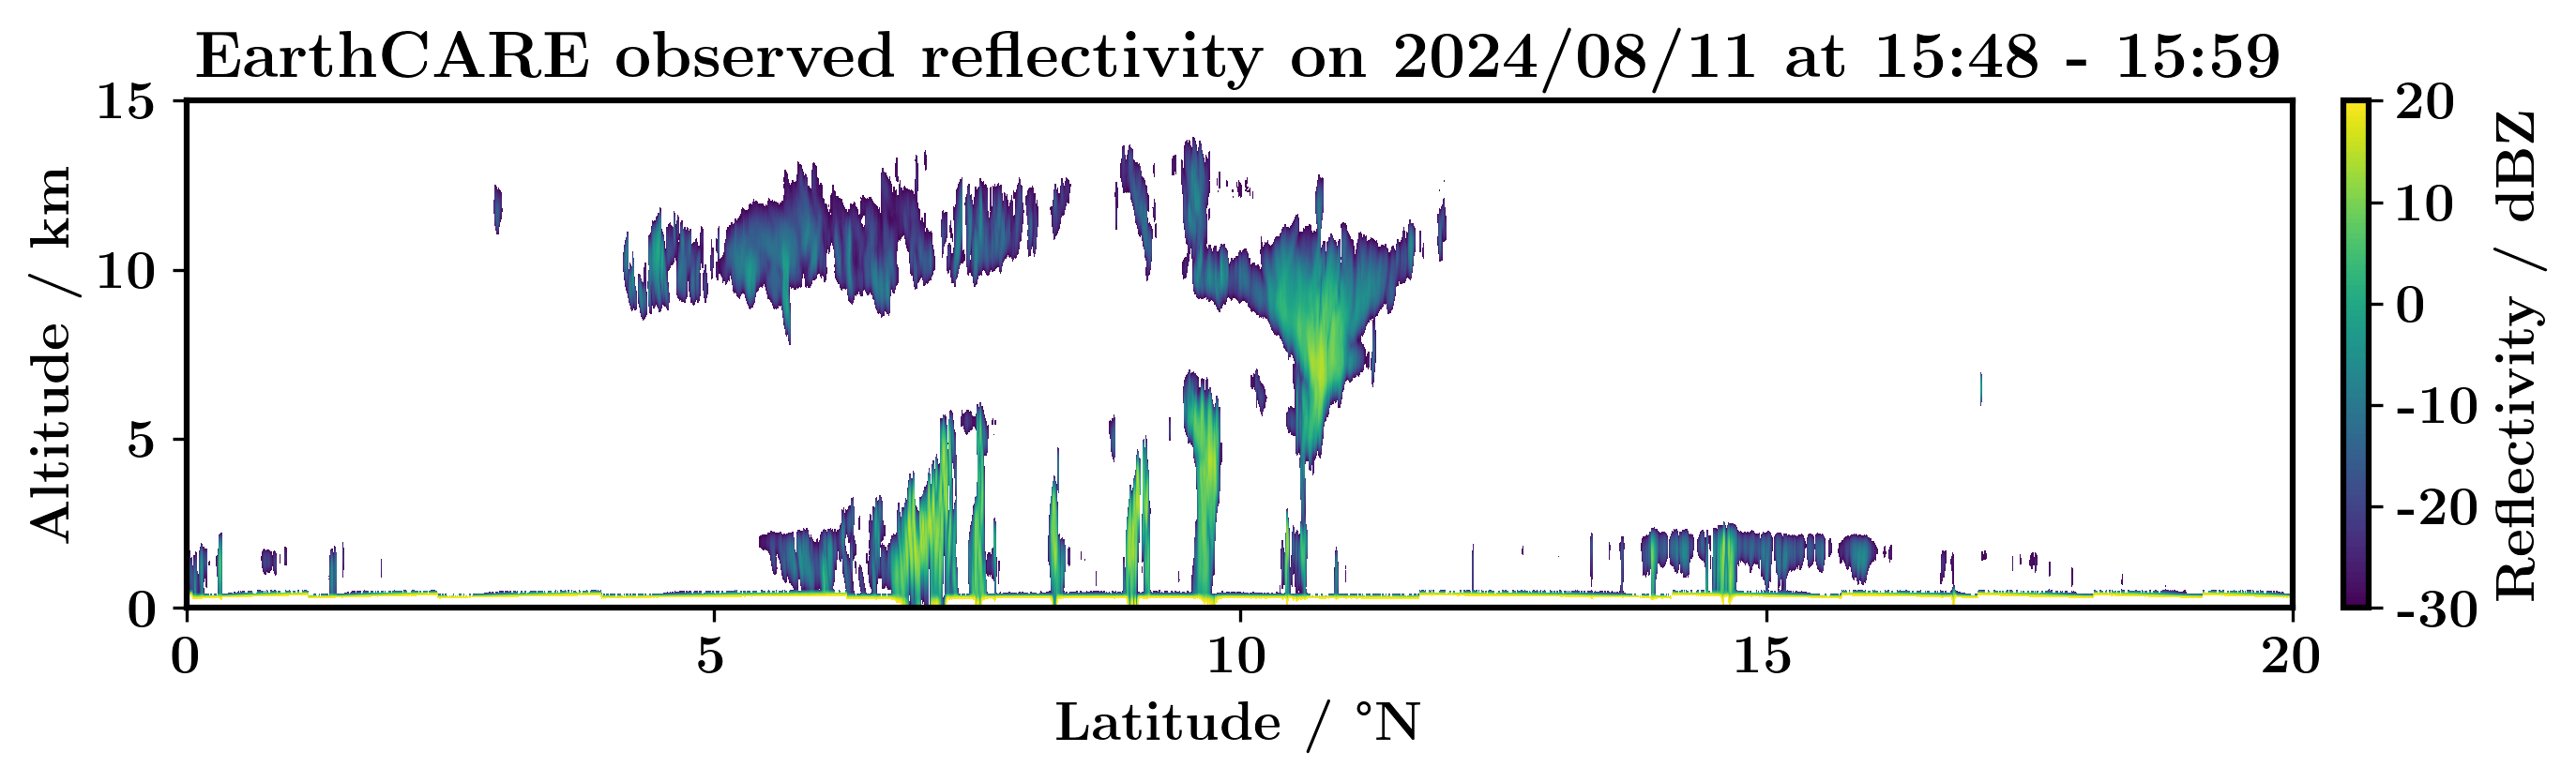

In [50]:
day = file_earthcare.split('T')[0][:10]
first_earthcare_time = file_earthcare.split('T')[1][:4]
second_earthcare_time = file_earthcare.split('T')[2][:4]
first_earthcare_time = first_earthcare_time[:2]+":"+first_earthcare_time[2:4]
second_earthcare_time = second_earthcare_time[:2]+":"+second_earthcare_time[2:4]

#Maybe you don't need the interpolation for now but it will be useful to compare with the models
#Interpolate bin with height to create a 1D altitude field
altitude_1d = ds_earthcare["height"].mean(dim="ray").values  # Compute the mean height across all rays for each bin
valid_mask = ~np.isnan(altitude_1d)
altitude_clean = altitude_1d[valid_mask]
ds_ec_interpolated = ds_earthcare.isel(bin=np.where(valid_mask)[0])

ds_ec_interpolated = ds_ec_interpolated.assign_coords(altitude=("bin", altitude_clean))
ds_ec_interpolated = ds_ec_interpolated.swap_dims({"bin": "altitude"})

ds_ec_interpolated2 = xr.Dataset()
for var in ds_ec_interpolated.data_vars:
    if 'altitude' in ds_ec_interpolated[var].dims:
        ds_ec_interpolated2[var] = ds_ec_interpolated[var].interp(altitude=zz, method='linear')
    else:
        ds_ec_interpolated2[var]=ds_ec_interpolated[var]

reflectivity = ds_ec_interpolated2['reflectivity']
reflectivity = np.where(reflectivity < -31, np.nan, reflectivity) # Delete noise

height = ds_ec_interpolated2['altitude']
lat = ds_ec_interpolated2['lat']
lon = ds_ec_interpolated2['lon']

# #PLOTTING
#Prepare the reflectivity scale
vmin = -30
vmax = 20
colorbar_ticks = np.arange(-30, vmax + 1, 10)

plt.figure(figsize=(10, 3))

contour = plt.contourf(
        lat, 
        height, 
        reflectivity.transpose(), 
        levels=np.linspace(vmin, vmax, 100),  # Ensure consistent levels
        vmin=vmin,
        vmax=vmax,
        
    )

plt.title(r'\textbf{EarthCARE observed reflectivity on ' + f'{day}' + ' at ' + f'{first_earthcare_time} - {second_earthcare_time}' + '}')
plt.xlabel(r'\textbf{Latitude / °N}')
plt.xticks([0, 5, 10, 15, 20], labels=[r'\textbf{0}', r'\textbf{5}', r'\textbf{10}', r'\textbf{15}', r'\textbf{20}'])
plt.ylabel(r'\textbf{Altitude / km}')
plt.yticks([0, 5000, 10000, 15000], labels=[r'\textbf{0}', r'\textbf{5}', r'\textbf{10}', r'\textbf{15}'])  # Set y-ticks at specific values

plt.xlim(0, 20)
plt.ylim(0, 15000)

cbar = plt.colorbar(contour, ticks=colorbar_ticks, pad=0.02)
cbar.set_label(r'\textbf{Reflectivity / dBZ}', color='black')
cbar.ax.set_yticklabels([f'\\textbf{{{tick}}}' for tick in colorbar_ticks])

plt.tight_layout()
plt.show()